# imports

In [11]:
# Dataset preprocessor to prepare the data for training
import numpy as np
import torch
import pickle
import os
import optuna

from time import time
import scipy.io as sio
import matplotlib.pyplot as plt

from NTdatasets.generic import GenericDataset
from NTdatasets.cumming.monocular import MultiDataset
import NTdatasets.conway.cloud_datasets as datasets

import ColorDataUtils.ConwayUtils as CU
import ColorDataUtils.EyeTrackingUtils as ETutils

# NDN tools
import NDNT.utils as utils # some other utilities
import NDNT.NDNT as NDN
from NDNT.modules.layers import *
from NDNT.networks import *
from time import time
from copy import deepcopy

import sys
sys.path.append('./lib')
import runner2 as r
import model as m
import experiment as exp
import plot

from NDNT.utils import imagesc   # because I'm lazy
from NDNT.utils import ss        # because I'm real lazy

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
datadir = '/home/dbutts/ColorV1/Data/'
dirname = '/home/dbutts/ColorV1/CLRworkspace/'
fn = 'Jocamo_220715_full_CC_ETCC_nofix_v08'
#fn = 'Jocamo_220727_full_CC_ETCC_nofix_v08'
num_lags=12

# load data

In [3]:
t0 = time()
data = datasets.ColorClouds(
    datadir=datadir, filenames=[fn], eye_config=3, drift_interval=16,
    luminance_only=True, binocular=False, include_MUs=True, num_lags=num_lags,
    trial_sample=True)
t1 = time()
print(t1-t0, 'sec elapsed')

Reducing stimulus channels (3) to first dimension
Loading data into memory...
Adjusting stimulus read from disk: mean | std = -0.000 | 0.269
T-range: 0 167520
  Trimming experiment 365280->167520 time points based on eye_config and Tmax
107.76439118385315 sec elapsed


In [4]:
NT = data.robs.shape[0]
NA = data.Xdrift.shape[1]
print("%d (%d valid) time points"%(NT, len(data)))
#data.valid_inds = np.arange(NT, dtype=np.int64)

lam_units = np.where(data.channel_map < 32)[0]
ETunits = np.where(data.channel_map >= 32)[0]
UTunits = np.where(data.channel_map >= 32+127)[0]

print( "%d laminar units, %d ET units"%(len(lam_units), len(ETunits)))

# Replace DFs
matdat = sio.loadmat(datadir+'Jocamo_220715_full_CC_ETCC_nofix_v08_DFextra.mat')
data.dfs = torch.tensor( matdat['XDF'][:NT, :], dtype=torch.float32 )

# Pull correct saccades
matdat = sio.loadmat(datadir+'Jocamo_220715_full_CC_ETCC_v08_ETupdate.mat')
sac_ts_all = matdat['ALLsac_bins'][0, :]

data.process_fixations( sac_ts_all )
sac_tsB = matdat['sac_binsB'][0, :]
sac_tsL = matdat['sac_binsL'][0, :]
sac_tsR = matdat['sac_binsR'][0, :]

NFIX = torch.max(data.fix_n).detach().numpy()
print(NFIX, 'fixations')
et1kHzB = matdat['et1kHzB']
et60B = matdat['et60HzB']
et60all = matdat['et60Hz_all']

print(lam_units, 'laminar units', data.robs.shape, 'robs', data.dfs.shape, 'dfs')

167520 (167520 valid) time points
29 laminar units, 210 ET units
  Redoing fix_n with saccade inputs: 6827 saccades
3795 fixations
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14 128 129 130
 131 132 133 134 135 136 137 138 139 140 141] laminar units torch.Size([167520, 239]) robs torch.Size([167520, 239]) dfs


21 out of 29 units used
Output set to 21 cells


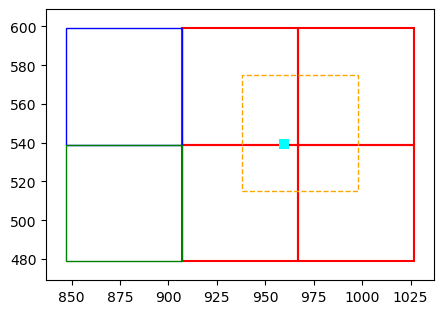

  Stim expansion for shift: [918, 495, 1018, 595]
  Writing lam stim 0: overlap 49, 44
  Writing lam stim 1: overlap 49, 56
  Writing lam stim 2: overlap 51, 56
  Writing lam stim 3: overlap 51, 44
  Adding fixation point
  Shifting stim...
  CROP: New stim size: 60 x 60
  Done


In [5]:
# Set cells-to-analyze and pull best model configuration and mus
Reff = torch.mul(data.robs[:, lam_units], data.dfs[:, lam_units]).numpy()
nspks = np.sum(Reff, axis=0)
a = np.where(nspks > 10)[0]
vallam = lam_units[a]
NCv = len(vallam)
print("%d out of %d units used"%(len(vallam), len(lam_units)))

## CONVERT LLsNULL, which is based on 

# Read in previous data
dirname2 = dirname+'0715/et/'
matdat = sio.loadmat(dirname2+'LLsGLM.mat')
Dreg = matdat['Dreg']
top_cornerUT = matdat['top_corner'][:, 0]

data.set_cells(vallam)

# Load shifts and previous models
dirname2 = dirname+'0715/et/'
SHfile = sio.loadmat( dirname2 + 'BDshifts1.mat' )
fix_n = SHfile['fix_n']
shifts = SHfile['shifts']
metricsLL = SHfile['metricsLL']
metricsTH = SHfile['metricsTH']
ETshifts = SHfile['ETshifts']
ETmetrics = SHfile['ETmetrics']
Ukeeps = SHfile['Ctrain']
XVkeeps = SHfile['Cval']

top_corner_lam = [938, 515]

# Make 60x60 STAs (and GLMs)
Xshift = 0 #8+4 
Yshift = 0 #-10+4
NX = 60

new_tc = np.array([top_corner_lam[0]-Xshift, top_corner_lam[1]-Yshift], dtype=np.int64)
data.draw_stim_locations(top_corner = new_tc, L=NX)

data.assemble_stimulus(top_corner=[new_tc[0], new_tc[1]], L=NX, fixdot=0, shifts=-shifts)


goodfix = np.where(ETmetrics[:,1] < 0.80)[0]
valfix = torch.zeros([ETmetrics.shape[0], 1], dtype=torch.float32)
valfix[goodfix] = 1.0
# Test base-level performance (full DFs and then modify DFs)
#DFsave = deepcopy(data2.dfs)  # this is also in data.dfs
data.dfs_out *= valfix

In [10]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device0 = torch.device("cpu")
dtype = torch.float32

goodfix = np.where(ETmetrics[:,1] < 0.80)[0]
valfix = torch.zeros([ETmetrics.shape[0], 1], dtype=torch.float32)
valfix[goodfix] = 1.0
print("%0.1f%% fixations remaining"%(100*len(goodfix)/ETmetrics.shape[0]))

68.5% fixations remaining


# STAs

In [6]:
Reff = torch.mul(data.robs[:, vallam], data.dfs[:, vallam])
nspks = torch.sum(Reff, axis=0)
lag = 4
stas0 = ((data.stim[:-lag, ...].T @ Reff[lag:,:]).squeeze() / nspks).reshape([60,60,-1]).numpy()

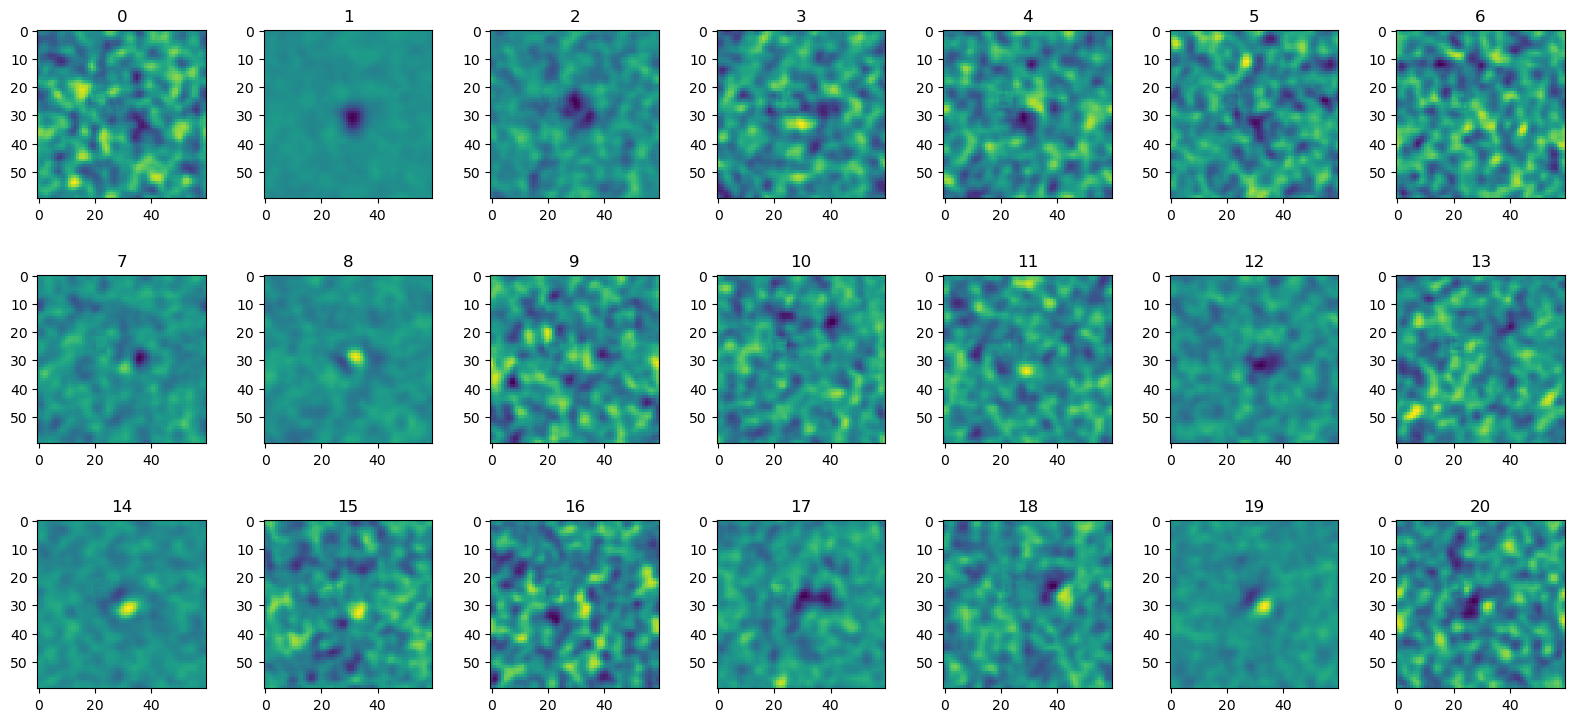

In [7]:
NCv = len(vallam)
ss(3,7)
for cc in range(NCv):
    plt.subplot(3,7, cc+1)
    imagesc(stas0[:,:, cc])
    plt.title(str(cc))
plt.show()

In [14]:
driftmods = []
glms = []
glm2s = []
gqms = []

class Model:
    def __init__(self, ndn_model, LLs, trial):
        self.ndn_model = ndn_model
        self.LLs = LLs
        self.trial = trial

# Drift

In [25]:
for cc in range(NCv):
    # # continue if the file already exists
    if os.path.isfile('models/color_02/drift_cc'+str(cc)+'.pkl'):
        # load the model and continue
        print('loading model', cc)
        with open('models/color_02/drift_cc'+str(cc)+'.pkl', 'rb') as f:
            driftmods.append(pickle.load(f))
        continue

    data.set_cells([vallam[cc]])
     
    models = []
    
    def objective(trial):    
        lbfgs_pars = utils.create_optimizer_params(
            optimizer_type='lbfgs',
            tolerance_change=trial.suggest_float('tolerance_change', 1e-8, 1e-4, log=True),
            tolerance_grad=trial.suggest_float('tolerance_grad', 1e-8, 1e-4, log=True),
            history_size=100,
            batch_size=20,
            max_epochs=3,
            max_iter = 500,
            device = device)
        
        # drift network
        drift_pars1 = NDNLayer.layer_dict(
            input_dims=[1,1,1,NA], num_filters=1, bias=False, norm_type=0, NLtype='lin')
        drift_pars1['reg_vals'] = {'d2t': trial.suggest_float('d2t', 0.0, 1.0), 'bcs':{'d2t':0} }
        # for stand-alone drift model
        drift_pars1N = deepcopy(drift_pars1)
        drift_pars1N['NLtype'] = 'softplus'
        drift_net =  FFnetwork.ffnet_dict( xstim_n = 'Xdrift', layer_list = [drift_pars1] )

        drift_ndn = NDN.NDN(
            layer_list = [drift_pars1N], loss_type='poisson')
        drift_ndn.block_sample=True
        drift_ndn.networks[0].xstim_n = 'Xdrift'

        drift_ndn.fit( data, force_dict_training=True, train_inds=None, **lbfgs_pars, verbose=0, version=1)
        LLsNULL = drift_ndn.eval_models(data[data.val_blks], null_adjusted=False)[0]
        
        drift_model = Model(drift_ndn, LLsNULL, trial)
        models.append(drift_model)
            
        return np.mean(LLsNULL)

    study = optuna.create_study(direction='maximize')
    
    # enqueue initial parameters
    study.enqueue_trial( 
        {'d2t': Dreg,
         'tolerance_change': 1e-8,
         'tolerance_grad': 1e-8})
    
    study.optimize(objective, n_trials=10)
    
    with open('models/color_02/drift_cc'+str(cc)+'.pkl', 'wb') as f:
        pickle.dump(models[study.best_trial.number], f)
    
    print(study.best_trial.number, study.best_params)

[I 2023-06-30 17:55:49,923] A new study created in memory with name: no-name-268cd8a2-5e75-40cb-8682-f330ba4aee62


Output set to 1 cells


[I 2023-06-30 17:55:50,480] Trial 0 finished with value: 4.8887481689453125 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2t': 0.1}. Best is trial 0 with value: 4.8887481689453125.
[I 2023-06-30 17:55:50,920] Trial 1 finished with value: 4.89316463470459 and parameters: {'tolerance_change': 1.268808145771392e-05, 'tolerance_grad': 1.3056347201049154e-08, 'd2t': 0.08434285178336998}. Best is trial 1 with value: 4.89316463470459.
[I 2023-06-30 17:55:51,401] Trial 2 finished with value: 4.909045219421387 and parameters: {'tolerance_change': 4.6841856279583806e-05, 'tolerance_grad': 2.017427958073387e-08, 'd2t': 0.936510358861603}. Best is trial 2 with value: 4.909045219421387.
[I 2023-06-30 17:55:52,024] Trial 3 finished with value: 4.888699531555176 and parameters: {'tolerance_change': 1.4484700493016216e-08, 'tolerance_grad': 1.268961185347136e-07, 'd2t': 0.20374881974048253}. Best is trial 2 with value: 4.909045219421387.
[I 2023-06-30 17:55:52,642] Trial 4 fin

2 {'tolerance_change': 4.6841856279583806e-05, 'tolerance_grad': 2.017427958073387e-08, 'd2t': 0.936510358861603}
Output set to 1 cells


[I 2023-06-30 17:55:56,400] Trial 0 finished with value: 2.1308462619781494 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2t': 0.1}. Best is trial 0 with value: 2.1308462619781494.
[I 2023-06-30 17:55:56,834] Trial 1 finished with value: 2.130991220474243 and parameters: {'tolerance_change': 1.5664056311768515e-07, 'tolerance_grad': 2.0568956095951568e-08, 'd2t': 0.253948855395275}. Best is trial 1 with value: 2.130991220474243.
[I 2023-06-30 17:55:57,300] Trial 2 finished with value: 2.130985736846924 and parameters: {'tolerance_change': 4.0807595209980226e-08, 'tolerance_grad': 4.562333495143828e-07, 'd2t': 0.31688675449725645}. Best is trial 1 with value: 2.130991220474243.
[I 2023-06-30 17:55:57,738] Trial 3 finished with value: 2.131544589996338 and parameters: {'tolerance_change': 2.207267195315522e-05, 'tolerance_grad': 3.0796349368021385e-08, 'd2t': 0.8407915940170567}. Best is trial 3 with value: 2.131544589996338.
[I 2023-06-30 17:55:58,219] Trial 4 f

3 {'tolerance_change': 2.207267195315522e-05, 'tolerance_grad': 3.0796349368021385e-08, 'd2t': 0.8407915940170567}
Output set to 1 cells


[I 2023-06-30 17:56:01,099] Trial 0 finished with value: 3.041670322418213 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2t': 0.1}. Best is trial 0 with value: 3.041670322418213.
[I 2023-06-30 17:56:01,828] Trial 1 finished with value: 3.042454957962036 and parameters: {'tolerance_change': 7.076724277977811e-08, 'tolerance_grad': 4.525238841804197e-06, 'd2t': 0.4714243063739446}. Best is trial 1 with value: 3.042454957962036.
[I 2023-06-30 17:56:02,350] Trial 2 finished with value: 3.0453405380249023 and parameters: {'tolerance_change': 1.4865141752195121e-06, 'tolerance_grad': 2.2850332594522152e-07, 'd2t': 0.27353709550477057}. Best is trial 2 with value: 3.0453405380249023.
[I 2023-06-30 17:56:03,202] Trial 3 finished with value: 3.0434579849243164 and parameters: {'tolerance_change': 1.4813408629368468e-07, 'tolerance_grad': 2.8552936507277064e-06, 'd2t': 0.9616526878165274}. Best is trial 2 with value: 3.0453405380249023.
[I 2023-06-30 17:56:03,863] Trial 

8 {'tolerance_change': 2.194431156967759e-06, 'tolerance_grad': 1.9697328930283775e-06, 'd2t': 0.7732613425507107}
Output set to 1 cells


[I 2023-06-30 17:56:08,025] Trial 0 finished with value: 4.1579270362854 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2t': 0.1}. Best is trial 0 with value: 4.1579270362854.
[I 2023-06-30 17:56:08,478] Trial 1 finished with value: 4.159471035003662 and parameters: {'tolerance_change': 3.921532841781159e-06, 'tolerance_grad': 1.2037009799697175e-05, 'd2t': 0.016849282345879013}. Best is trial 1 with value: 4.159471035003662.
[I 2023-06-30 17:56:09,375] Trial 2 finished with value: 4.166847229003906 and parameters: {'tolerance_change': 2.918499160159096e-07, 'tolerance_grad': 2.7503165479934123e-08, 'd2t': 0.534469056792893}. Best is trial 2 with value: 4.166847229003906.
[I 2023-06-30 17:56:09,830] Trial 3 finished with value: 4.308161735534668 and parameters: {'tolerance_change': 6.447044494083922e-05, 'tolerance_grad': 1.7491642502902223e-05, 'd2t': 0.3481122878213747}. Best is trial 3 with value: 4.308161735534668.
[I 2023-06-30 17:56:10,411] Trial 4 finishe

3 {'tolerance_change': 6.447044494083922e-05, 'tolerance_grad': 1.7491642502902223e-05, 'd2t': 0.3481122878213747}
Output set to 1 cells


[I 2023-06-30 17:56:14,539] Trial 0 finished with value: 4.9823317527771 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2t': 0.1}. Best is trial 0 with value: 4.9823317527771.
[I 2023-06-30 17:56:15,169] Trial 1 finished with value: 4.983809471130371 and parameters: {'tolerance_change': 7.138168247869819e-07, 'tolerance_grad': 2.2666829650597343e-07, 'd2t': 0.6955161988329447}. Best is trial 1 with value: 4.983809471130371.
[I 2023-06-30 17:56:15,763] Trial 2 finished with value: 4.982575416564941 and parameters: {'tolerance_change': 1.7360943372195112e-08, 'tolerance_grad': 5.5785847294343155e-05, 'd2t': 0.261851334832208}. Best is trial 1 with value: 4.983809471130371.
[I 2023-06-30 17:56:16,522] Trial 3 finished with value: 4.983044147491455 and parameters: {'tolerance_change': 4.584086357030682e-08, 'tolerance_grad': 3.403248035360389e-07, 'd2t': 0.8796173424501961}. Best is trial 1 with value: 4.983809471130371.
[I 2023-06-30 17:56:17,241] Trial 4 finished 

6 {'tolerance_change': 3.849499235345345e-05, 'tolerance_grad': 2.0076705171866776e-07, 'd2t': 0.7901369230748343}
Output set to 1 cells


[I 2023-06-30 17:56:20,871] Trial 0 finished with value: 4.738723278045654 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2t': 0.1}. Best is trial 0 with value: 4.738723278045654.
[I 2023-06-30 17:56:21,520] Trial 1 finished with value: 4.732149124145508 and parameters: {'tolerance_change': 1.9754952985474608e-06, 'tolerance_grad': 1.5541993174091428e-06, 'd2t': 0.6607472509448458}. Best is trial 0 with value: 4.738723278045654.
[I 2023-06-30 17:56:22,362] Trial 2 finished with value: 4.739418983459473 and parameters: {'tolerance_change': 1.6413304226900142e-08, 'tolerance_grad': 8.491643919712163e-06, 'd2t': 0.7532614795719373}. Best is trial 2 with value: 4.739418983459473.
[I 2023-06-30 17:56:22,875] Trial 3 finished with value: 4.730771064758301 and parameters: {'tolerance_change': 1.3911573748245733e-05, 'tolerance_grad': 2.0385007140773077e-06, 'd2t': 0.363029027426223}. Best is trial 2 with value: 4.739418983459473.
[I 2023-06-30 17:56:23,492] Trial 4 fin

6 {'tolerance_change': 2.6512009253120232e-05, 'tolerance_grad': 5.851346878219939e-08, 'd2t': 0.8662331289725496}
Output set to 1 cells


[I 2023-06-30 17:56:27,222] Trial 0 finished with value: 4.376742839813232 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2t': 0.1}. Best is trial 0 with value: 4.376742839813232.
[I 2023-06-30 17:56:27,659] Trial 1 finished with value: 4.45161771774292 and parameters: {'tolerance_change': 4.7501509187475216e-05, 'tolerance_grad': 1.5777671825417313e-08, 'd2t': 0.34584813224595234}. Best is trial 1 with value: 4.45161771774292.
[I 2023-06-30 17:56:28,309] Trial 2 finished with value: 4.377851486206055 and parameters: {'tolerance_change': 2.847688074341164e-07, 'tolerance_grad': 1.2085586973447903e-08, 'd2t': 0.32501525885424176}. Best is trial 1 with value: 4.45161771774292.
[I 2023-06-30 17:56:28,871] Trial 3 finished with value: 4.3767876625061035 and parameters: {'tolerance_change': 8.105301435611044e-08, 'tolerance_grad': 1.7090567449736943e-07, 'd2t': 0.09824294011459866}. Best is trial 1 with value: 4.45161771774292.
[I 2023-06-30 17:56:29,631] Trial 4 fin

1 {'tolerance_change': 4.7501509187475216e-05, 'tolerance_grad': 1.5777671825417313e-08, 'd2t': 0.34584813224595234}
Output set to 1 cells


[I 2023-06-30 17:56:33,254] Trial 0 finished with value: 3.003512382507324 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2t': 0.1}. Best is trial 0 with value: 3.003512382507324.
[I 2023-06-30 17:56:33,686] Trial 1 finished with value: 3.003626585006714 and parameters: {'tolerance_change': 1.1404948139895678e-05, 'tolerance_grad': 1.3710212412899456e-08, 'd2t': 0.15952182051141595}. Best is trial 1 with value: 3.003626585006714.
[I 2023-06-30 17:56:34,291] Trial 2 finished with value: 3.003425359725952 and parameters: {'tolerance_change': 4.23305565395707e-08, 'tolerance_grad': 4.3680250463434025e-07, 'd2t': 0.8901752818302494}. Best is trial 1 with value: 3.003626585006714.
[I 2023-06-30 17:56:34,824] Trial 3 finished with value: 3.0034103393554688 and parameters: {'tolerance_change': 2.399904821586578e-07, 'tolerance_grad': 1.844311012797174e-07, 'd2t': 0.53182011833965}. Best is trial 1 with value: 3.003626585006714.
[I 2023-06-30 17:56:35,368] Trial 4 finis

1 {'tolerance_change': 1.1404948139895678e-05, 'tolerance_grad': 1.3710212412899456e-08, 'd2t': 0.15952182051141595}
Output set to 1 cells


[I 2023-06-30 17:56:38,451] Trial 0 finished with value: 1.9041332006454468 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2t': 0.1}. Best is trial 0 with value: 1.9041332006454468.
[I 2023-06-30 17:56:38,881] Trial 1 finished with value: 1.9044791460037231 and parameters: {'tolerance_change': 1.9708095031344378e-05, 'tolerance_grad': 1.029675272242926e-05, 'd2t': 0.7086477738255561}. Best is trial 1 with value: 1.9044791460037231.
[I 2023-06-30 17:56:39,323] Trial 2 finished with value: 1.9041649103164673 and parameters: {'tolerance_change': 1.6012059890353177e-06, 'tolerance_grad': 6.7920007026911515e-06, 'd2t': 0.3358362289896396}. Best is trial 1 with value: 1.9044791460037231.
[I 2023-06-30 17:56:39,836] Trial 3 finished with value: 1.9041638374328613 and parameters: {'tolerance_change': 1.615129096167082e-08, 'tolerance_grad': 5.74451817700588e-05, 'd2t': 0.9659197087191836}. Best is trial 1 with value: 1.9044791460037231.
[I 2023-06-30 17:56:40,261] Trial

4 {'tolerance_change': 3.2640295821695765e-05, 'tolerance_grad': 2.9806994975925116e-07, 'd2t': 0.49035349305825005}
Output set to 1 cells


[I 2023-06-30 17:56:43,248] Trial 0 finished with value: 4.658034324645996 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2t': 0.1}. Best is trial 0 with value: 4.658034324645996.
[I 2023-06-30 17:56:44,041] Trial 1 finished with value: 4.656978607177734 and parameters: {'tolerance_change': 4.2122192905197826e-08, 'tolerance_grad': 6.507679072790361e-06, 'd2t': 0.908867186012075}. Best is trial 0 with value: 4.658034324645996.
[I 2023-06-30 17:56:44,537] Trial 2 finished with value: 4.714906215667725 and parameters: {'tolerance_change': 8.723710124183447e-05, 'tolerance_grad': 6.337120615565696e-07, 'd2t': 0.4657786061129161}. Best is trial 2 with value: 4.714906215667725.
[I 2023-06-30 17:56:45,177] Trial 3 finished with value: 4.655742645263672 and parameters: {'tolerance_change': 4.09594906882923e-06, 'tolerance_grad': 3.4527215852998554e-06, 'd2t': 0.4248113203542746}. Best is trial 2 with value: 4.714906215667725.
[I 2023-06-30 17:56:45,993] Trial 4 finishe

7 {'tolerance_change': 6.546686641302344e-05, 'tolerance_grad': 1.2762515845882513e-06, 'd2t': 0.44515321439381306}
Output set to 1 cells


[I 2023-06-30 17:56:49,746] Trial 0 finished with value: 4.416576862335205 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2t': 0.1}. Best is trial 0 with value: 4.416576862335205.
[I 2023-06-30 17:56:50,267] Trial 1 finished with value: 4.420424461364746 and parameters: {'tolerance_change': 7.386155024589559e-05, 'tolerance_grad': 2.115303536845855e-05, 'd2t': 0.9350262661966913}. Best is trial 1 with value: 4.420424461364746.
[I 2023-06-30 17:56:50,827] Trial 2 finished with value: 4.41964054107666 and parameters: {'tolerance_change': 6.7828896151245715e-06, 'tolerance_grad': 8.330569776015331e-07, 'd2t': 0.6258372677509716}. Best is trial 1 with value: 4.420424461364746.
[I 2023-06-30 17:56:51,247] Trial 3 finished with value: 4.417058944702148 and parameters: {'tolerance_change': 9.485223894081194e-07, 'tolerance_grad': 1.2643814620040721e-08, 'd2t': 0.006916173319508445}. Best is trial 1 with value: 4.420424461364746.
[I 2023-06-30 17:56:51,717] Trial 4 fini

4 {'tolerance_change': 6.700644203676136e-05, 'tolerance_grad': 5.3536328776262506e-08, 'd2t': 0.5714098255933296}
Output set to 1 cells


[I 2023-06-30 17:56:55,583] Trial 0 finished with value: 5.122799396514893 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2t': 0.1}. Best is trial 0 with value: 5.122799396514893.
[I 2023-06-30 17:56:56,242] Trial 1 finished with value: 5.157942771911621 and parameters: {'tolerance_change': 1.34419277998958e-06, 'tolerance_grad': 2.3126557559947154e-08, 'd2t': 0.20375975231477472}. Best is trial 1 with value: 5.157942771911621.
[I 2023-06-30 17:56:56,906] Trial 2 finished with value: 5.080639362335205 and parameters: {'tolerance_change': 7.78197904802915e-06, 'tolerance_grad': 3.6170692802574655e-05, 'd2t': 0.7599609156696246}. Best is trial 1 with value: 5.157942771911621.
[I 2023-06-30 17:56:57,584] Trial 3 finished with value: 5.103954315185547 and parameters: {'tolerance_change': 3.1193078152791643e-06, 'tolerance_grad': 3.338946496751271e-07, 'd2t': 0.3693259990210769}. Best is trial 1 with value: 5.157942771911621.
[I 2023-06-30 17:56:58,482] Trial 4 finis

4 {'tolerance_change': 3.098835416819257e-08, 'tolerance_grad': 1.702517111797343e-08, 'd2t': 0.8636406380486664}
Output set to 1 cells


[I 2023-06-30 17:57:01,978] Trial 0 finished with value: 3.4857687950134277 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2t': 0.1}. Best is trial 0 with value: 3.4857687950134277.
[I 2023-06-30 17:57:02,445] Trial 1 finished with value: 3.4868011474609375 and parameters: {'tolerance_change': 4.801889057960486e-06, 'tolerance_grad': 2.400081367529344e-08, 'd2t': 0.3872433699346276}. Best is trial 1 with value: 3.4868011474609375.
[I 2023-06-30 17:57:02,894] Trial 2 finished with value: 3.4846279621124268 and parameters: {'tolerance_change': 3.2177800982143215e-05, 'tolerance_grad': 4.306239586785005e-06, 'd2t': 0.2893616224378227}. Best is trial 1 with value: 3.4868011474609375.
[I 2023-06-30 17:57:03,346] Trial 3 finished with value: 3.4879608154296875 and parameters: {'tolerance_change': 8.412319027146454e-05, 'tolerance_grad': 2.0960810606012467e-07, 'd2t': 0.7296878066851101}. Best is trial 3 with value: 3.4879608154296875.
[I 2023-06-30 17:57:03,839] Trial

8 {'tolerance_change': 4.1198660293145485e-05, 'tolerance_grad': 1.222591800289638e-07, 'd2t': 0.17103766556643374}
Output set to 1 cells


[I 2023-06-30 17:57:06,762] Trial 0 finished with value: 5.055920600891113 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2t': 0.1}. Best is trial 0 with value: 5.055920600891113.
[I 2023-06-30 17:57:07,462] Trial 1 finished with value: 5.058396816253662 and parameters: {'tolerance_change': 2.606046459480133e-08, 'tolerance_grad': 6.981949559325777e-05, 'd2t': 0.8143952011898796}. Best is trial 1 with value: 5.058396816253662.
[I 2023-06-30 17:57:07,888] Trial 2 finished with value: 5.102438449859619 and parameters: {'tolerance_change': 8.154524453596021e-05, 'tolerance_grad': 5.255576929831054e-05, 'd2t': 0.39116043463180883}. Best is trial 2 with value: 5.102438449859619.
[I 2023-06-30 17:57:08,464] Trial 3 finished with value: 5.059844970703125 and parameters: {'tolerance_change': 1.7852233002399392e-05, 'tolerance_grad': 1.686737269228391e-08, 'd2t': 0.7695985918906723}. Best is trial 2 with value: 5.102438449859619.
[I 2023-06-30 17:57:09,042] Trial 4 finis

2 {'tolerance_change': 8.154524453596021e-05, 'tolerance_grad': 5.255576929831054e-05, 'd2t': 0.39116043463180883}
Output set to 1 cells


[I 2023-06-30 17:57:12,747] Trial 0 finished with value: 3.715280055999756 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2t': 0.1}. Best is trial 0 with value: 3.715280055999756.
[I 2023-06-30 17:57:13,254] Trial 1 finished with value: 3.71612286567688 and parameters: {'tolerance_change': 2.0311615113055268e-07, 'tolerance_grad': 1.0502894417152633e-06, 'd2t': 0.17797335732741282}. Best is trial 1 with value: 3.71612286567688.
[I 2023-06-30 17:57:13,836] Trial 2 finished with value: 3.7207417488098145 and parameters: {'tolerance_change': 1.3248329728226428e-06, 'tolerance_grad': 6.744086984343825e-06, 'd2t': 0.6161213744612766}. Best is trial 2 with value: 3.7207417488098145.
[I 2023-06-30 17:57:14,283] Trial 3 finished with value: 3.7190706729888916 and parameters: {'tolerance_change': 8.531347729780946e-05, 'tolerance_grad': 3.738337561207055e-08, 'd2t': 0.7462114916569953}. Best is trial 2 with value: 3.7207417488098145.
[I 2023-06-30 17:57:14,834] Trial 4 f

2 {'tolerance_change': 1.3248329728226428e-06, 'tolerance_grad': 6.744086984343825e-06, 'd2t': 0.6161213744612766}
Output set to 1 cells


[I 2023-06-30 17:57:17,677] Trial 0 finished with value: 4.371939182281494 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2t': 0.1}. Best is trial 0 with value: 4.371939182281494.
[I 2023-06-30 17:57:18,366] Trial 1 finished with value: 4.372891902923584 and parameters: {'tolerance_change': 1.1065688618774935e-08, 'tolerance_grad': 4.804062958939324e-08, 'd2t': 0.50316931283475}. Best is trial 1 with value: 4.372891902923584.
[I 2023-06-30 17:57:18,837] Trial 2 finished with value: 4.3718976974487305 and parameters: {'tolerance_change': 1.9115926503873903e-07, 'tolerance_grad': 2.0172075436681227e-07, 'd2t': 0.10311597493747748}. Best is trial 1 with value: 4.372891902923584.
[I 2023-06-30 17:57:19,471] Trial 3 finished with value: 4.372824668884277 and parameters: {'tolerance_change': 9.52669463401084e-08, 'tolerance_grad': 3.051896817202978e-06, 'd2t': 0.5116907706092936}. Best is trial 1 with value: 4.372891902923584.
[I 2023-06-30 17:57:19,892] Trial 4 finis

4 {'tolerance_change': 6.378831800048237e-05, 'tolerance_grad': 1.1169100378822082e-07, 'd2t': 0.194814310554681}
Output set to 1 cells


[I 2023-06-30 17:57:23,032] Trial 0 finished with value: 4.226120471954346 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2t': 0.1}. Best is trial 0 with value: 4.226120471954346.
[I 2023-06-30 17:57:23,586] Trial 1 finished with value: 4.226623058319092 and parameters: {'tolerance_change': 2.240036140612999e-08, 'tolerance_grad': 1.2908074805404096e-06, 'd2t': 0.15468973315023393}. Best is trial 1 with value: 4.226623058319092.
[I 2023-06-30 17:57:24,284] Trial 2 finished with value: 4.227982044219971 and parameters: {'tolerance_change': 4.5557745837680365e-08, 'tolerance_grad': 4.409653640948028e-06, 'd2t': 0.6891142242578633}. Best is trial 2 with value: 4.227982044219971.
[I 2023-06-30 17:57:24,738] Trial 3 finished with value: 4.227355480194092 and parameters: {'tolerance_change': 1.0573497765919148e-05, 'tolerance_grad': 2.2253443412371183e-06, 'd2t': 0.17712190202417133}. Best is trial 2 with value: 4.227982044219971.
[I 2023-06-30 17:57:25,335] Trial 4 f

6 {'tolerance_change': 5.8632375942968444e-05, 'tolerance_grad': 2.652018942678386e-07, 'd2t': 0.5238178438688381}
Output set to 1 cells


[I 2023-06-30 17:57:28,465] Trial 0 finished with value: 3.991168260574341 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2t': 0.1}. Best is trial 0 with value: 3.991168260574341.
[I 2023-06-30 17:57:28,916] Trial 1 finished with value: 3.993149518966675 and parameters: {'tolerance_change': 2.3461765928388287e-05, 'tolerance_grad': 4.126253099709094e-05, 'd2t': 0.2104269719578662}. Best is trial 1 with value: 3.993149518966675.
[I 2023-06-30 17:57:29,388] Trial 2 finished with value: 3.9973747730255127 and parameters: {'tolerance_change': 3.4206152696817834e-05, 'tolerance_grad': 1.4822136829649726e-07, 'd2t': 0.5936150081545547}. Best is trial 2 with value: 3.9973747730255127.
[I 2023-06-30 17:57:30,083] Trial 3 finished with value: 3.992093086242676 and parameters: {'tolerance_change': 2.4278650260681172e-08, 'tolerance_grad': 6.55389215615498e-07, 'd2t': 0.5942158510569505}. Best is trial 2 with value: 3.9973747730255127.
[I 2023-06-30 17:57:30,730] Trial 4 f

2 {'tolerance_change': 3.4206152696817834e-05, 'tolerance_grad': 1.4822136829649726e-07, 'd2t': 0.5936150081545547}
Output set to 1 cells


[I 2023-06-30 17:57:34,445] Trial 0 finished with value: 4.8363037109375 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2t': 0.1}. Best is trial 0 with value: 4.8363037109375.
[I 2023-06-30 17:57:35,015] Trial 1 finished with value: 4.849285125732422 and parameters: {'tolerance_change': 3.274792999497034e-06, 'tolerance_grad': 6.733330505486859e-06, 'd2t': 0.16923045369563983}. Best is trial 1 with value: 4.849285125732422.
[I 2023-06-30 17:57:35,901] Trial 2 finished with value: 4.839931011199951 and parameters: {'tolerance_change': 3.73864617428262e-07, 'tolerance_grad': 1.0024819859896865e-05, 'd2t': 0.3430851032169041}. Best is trial 1 with value: 4.849285125732422.
[I 2023-06-30 17:57:36,348] Trial 3 finished with value: 4.852995872497559 and parameters: {'tolerance_change': 2.3818403827007187e-07, 'tolerance_grad': 2.993163964974481e-08, 'd2t': 0.18822341972751222}. Best is trial 3 with value: 4.852995872497559.
[I 2023-06-30 17:57:37,322] Trial 4 finished

5 {'tolerance_change': 2.127292894734032e-06, 'tolerance_grad': 1.2523787681468484e-08, 'd2t': 0.904883725751787}
Output set to 1 cells


[I 2023-06-30 17:57:42,407] Trial 0 finished with value: 3.4942996501922607 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2t': 0.1}. Best is trial 0 with value: 3.4942996501922607.
[I 2023-06-30 17:57:42,980] Trial 1 finished with value: 3.4943878650665283 and parameters: {'tolerance_change': 2.3688536010318053e-06, 'tolerance_grad': 1.090118675627957e-07, 'd2t': 0.874025393115182}. Best is trial 1 with value: 3.4943878650665283.
[I 2023-06-30 17:57:43,848] Trial 2 finished with value: 3.4930992126464844 and parameters: {'tolerance_change': 1.9391210775156228e-08, 'tolerance_grad': 5.739043784345425e-08, 'd2t': 0.5295430716217334}. Best is trial 1 with value: 3.4943878650665283.
[I 2023-06-30 17:57:44,647] Trial 3 finished with value: 3.4931910037994385 and parameters: {'tolerance_change': 1.1228153227118193e-07, 'tolerance_grad': 9.019627662621286e-06, 'd2t': 0.4972250390134414}. Best is trial 1 with value: 3.4943878650665283.
[I 2023-06-30 17:57:45,207] Trial

5 {'tolerance_change': 9.963281682188565e-05, 'tolerance_grad': 8.805588183324487e-07, 'd2t': 0.9293254867681194}
Output set to 1 cells


[I 2023-06-30 17:57:48,869] Trial 0 finished with value: 4.622923851013184 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2t': 0.1}. Best is trial 0 with value: 4.622923851013184.
[I 2023-06-30 17:57:49,746] Trial 1 finished with value: 4.633728504180908 and parameters: {'tolerance_change': 1.6301577770474326e-07, 'tolerance_grad': 1.1923275529027761e-05, 'd2t': 0.6149707293117997}. Best is trial 1 with value: 4.633728504180908.
[I 2023-06-30 17:57:50,576] Trial 2 finished with value: 4.635803699493408 and parameters: {'tolerance_change': 2.411414060500105e-07, 'tolerance_grad': 9.721130838600074e-05, 'd2t': 0.7334613002616129}. Best is trial 2 with value: 4.635803699493408.
[I 2023-06-30 17:57:51,699] Trial 3 finished with value: 4.612612724304199 and parameters: {'tolerance_change': 1.313507240082191e-08, 'tolerance_grad': 1.364027004271467e-08, 'd2t': 0.8919876017397728}. Best is trial 2 with value: 4.635803699493408.
[I 2023-06-30 17:57:52,483] Trial 4 finis

9 {'tolerance_change': 4.127959529671708e-05, 'tolerance_grad': 1.2995910505262208e-05, 'd2t': 0.8746013020647689}


# GLM

In [31]:
for cc in range(NCv):
    glm_filename = 'models/color_02/glm_cc'+str(cc)+'.pkl'
    
    drift_weights = driftmods[cc].ndn_model.networks[0].layers[0].weight.data[:,0]
    
    # # continue if the file already exists
    if os.path.isfile(glm_filename):
        # load the model and continue
        print('loading model', cc)
        with open(glm_filename, 'rb') as f:
            glms.append(pickle.load(f))
        continue

    data.set_cells([vallam[cc]])
    
    models = []

    LLsNULL = driftmods[cc].LLs
    
    def objective(trial):
        lbfgs_pars = utils.create_optimizer_params(
            optimizer_type='lbfgs',
            tolerance_change=trial.suggest_float('tolerance_change', 1e-10, 1e-4, log=True),
            tolerance_grad=trial.suggest_float('tolerance_grad', 1e-10, 1e-4, log=True),
            history_size=100,
            batch_size=20,
            max_epochs=3,
            max_iter = 500,
            device = device)
        
        # drift network
        drift_pars1 = NDNLayer.layer_dict(
            input_dims=[1,1,1,NA], num_filters=1, bias=False, norm_type=0, NLtype='lin')
        # for stand-alone drift model
        drift_net =  FFnetwork.ffnet_dict( xstim_n = 'Xdrift', layer_list = [drift_pars1] )

        glm_layer = Tlayer.layer_dict(
            input_dims=data.stim_dims, num_filters=1, bias=False, num_lags=num_lags,
            NLtype='lin', initialize_center = True)
        glm_layer['reg_vals'] = {'d2x': trial.suggest_float('d2x', 1e-5, 1e5, log=True),
                                 'd2t': trial.suggest_float('d2t', 1e-5, 1e5, log=True),
                                 'l1': trial.suggest_float('l1', 1e-5, 1e5, log=True),
                                 'glocalx': trial.suggest_float('glocalx', 1e-5, 1e5, log=True),
                                 'edge_t': trial.suggest_float('edge_t', 1e-5, 1e5, log=True)}
        stim_net =  FFnetwork.ffnet_dict( xstim_n = 'stim', layer_list = [glm_layer] )

        comb_layer = NDNLayer.layer_dict(
            num_filters = 1, NLtype='softplus', bias=False)
        comb_layer['weights_initializer'] = 'ones'
        net_comb = FFnetwork.ffnet_dict(
            xstim_n = None, ffnet_n=[0,1],
            layer_list = [comb_layer], ffnet_type='add')

        glm_ndn = NDN.NDN(ffnet_list = [stim_net, drift_net, net_comb], loss_type='poisson')
        glm_ndn.block_sample=True
        glm_ndn.networks[1].layers[0].weight.data[:,0] = deepcopy(drift_weights)
        glm_ndn.networks[1].layers[0].set_parameters(val=False)
        glm_ndn.networks[2].layers[0].set_parameters(val=False,name='weight')

        glm_ndn.fit( data, force_dict_training=True, **lbfgs_pars)
        LLs = glm_ndn.eval_models(data[data.val_blks], null_adjusted=False)[0]
        null_adjusted_LLs = LLsNULL - LLs
        
        glm_model = Model(glm_ndn, null_adjusted_LLs, trial)
        models.append(glm_model)
        
        return np.mean(null_adjusted_LLs)

    study = optuna.create_study(direction='maximize')
    
    # enqueue initial parameters
    study.enqueue_trial( 
        {'d2t': 1,
         'd2x': 20,
         'l1': 0.1,
         'glocalx': 10.0,
         'edge_t': 10,
         'tolerance_change': 1e-8,
         'tolerance_grad': 1e-8})
    
    study.optimize(objective, n_trials=10)
    
    with open(glm_filename, 'wb') as f:
        pickle.dump(models[study.best_trial.number], f)
    
    print(study.best_trial.number, study.best_params)

[I 2023-06-30 18:18:35,016] A new study created in memory with name: no-name-be4954c5-4766-443f-a08f-3052729746bf


Output set to 1 cells

GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.6564443111419678 sec elapsed


[I 2023-06-30 18:18:38,430] Trial 0 finished with value: -0.012500286102294922 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2x': 20.0, 'd2t': 1.0, 'l1': 0.1, 'glocalx': 10.0, 'edge_t': 10.0}. Best is trial 0 with value: -0.012500286102294922.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 8.472005605697632 sec elapsed


[I 2023-06-30 18:18:47,660] Trial 1 finished with value: -0.01616048812866211 and parameters: {'tolerance_change': 3.863002940596452e-07, 'tolerance_grad': 7.017599543444989e-05, 'd2x': 0.0007737661410704864, 'd2t': 4482.911824580314, 'l1': 1.75575965604577, 'glocalx': 0.006696844377837097, 'edge_t': 3.5906415864822687}. Best is trial 0 with value: -0.012500286102294922.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.4955496788024902 sec elapsed


[I 2023-06-30 18:18:50,912] Trial 2 finished with value: -0.1276230812072754 and parameters: {'tolerance_change': 5.8780256679576895e-05, 'tolerance_grad': 6.412681223921975e-07, 'd2x': 0.005870573413583661, 'd2t': 781.0690829080179, 'l1': 0.30432338594201847, 'glocalx': 3.273311956912843e-05, 'edge_t': 3.769402821362565e-05}. Best is trial 0 with value: -0.012500286102294922.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 3.628929853439331 sec elapsed


[I 2023-06-30 18:18:55,317] Trial 3 finished with value: -0.0005688667297363281 and parameters: {'tolerance_change': 8.391305896887477e-10, 'tolerance_grad': 1.5160620385203782e-09, 'd2x': 341.9079620986621, 'd2t': 0.0006455469530251943, 'l1': 0.00770130037073312, 'glocalx': 11059.017818592327, 'edge_t': 1.2456897524221469e-05}. Best is trial 3 with value: -0.0005688667297363281.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 4.277838468551636 sec elapsed


[I 2023-06-30 18:19:00,370] Trial 4 finished with value: -0.00021648406982421875 and parameters: {'tolerance_change': 1.756594627449034e-07, 'tolerance_grad': 2.3464342705411987e-06, 'd2x': 25.940393673543817, 'd2t': 0.02126060185833685, 'l1': 0.01962863237329885, 'glocalx': 69897.34704655464, 'edge_t': 50843.56790995683}. Best is trial 4 with value: -0.00021648406982421875.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 9.886018753051758 sec elapsed


[I 2023-06-30 18:19:11,031] Trial 5 finished with value: -2.3365020751953125e-05 and parameters: {'tolerance_change': 3.7391215214552896e-08, 'tolerance_grad': 1.5612981342096708e-07, 'd2x': 2061.11511996678, 'd2t': 1.0516974883246013e-05, 'l1': 11.503211695720735, 'glocalx': 23720.892557428935, 'edge_t': 38.70616028513456}. Best is trial 5 with value: -2.3365020751953125e-05.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 3.2716102600097656 sec elapsed


[I 2023-06-30 18:19:15,059] Trial 6 finished with value: -0.0018057823181152344 and parameters: {'tolerance_change': 2.441680927504463e-09, 'tolerance_grad': 5.7857627858022465e-09, 'd2x': 0.0004442870187112885, 'd2t': 0.0001190860799341176, 'l1': 0.0006074176318739366, 'glocalx': 655.658502801309, 'edge_t': 0.0006296232546914582}. Best is trial 5 with value: -2.3365020751953125e-05.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 59.79527401924133 sec elapsed


[I 2023-06-30 18:20:15,612] Trial 7 finished with value: -0.00041961669921875 and parameters: {'tolerance_change': 2.5935587303480824e-10, 'tolerance_grad': 6.294821229646553e-08, 'd2x': 38856.14212175432, 'd2t': 1079.676872929696, 'l1': 68.28638905985335, 'glocalx': 37713.34911707506, 'edge_t': 1.1916636993773841}. Best is trial 5 with value: -2.3365020751953125e-05.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 6.558748483657837 sec elapsed


[I 2023-06-30 18:20:22,945] Trial 8 finished with value: -0.14550447463989258 and parameters: {'tolerance_change': 2.403679227700143e-10, 'tolerance_grad': 5.700469753736991e-10, 'd2x': 4210.085048779818, 'd2t': 4.320887596683038, 'l1': 0.0002267932991774413, 'glocalx': 0.0002638864311440528, 'edge_t': 4.093831863051017e-05}. Best is trial 5 with value: -2.3365020751953125e-05.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 60.23813843727112 sec elapsed


[I 2023-06-30 18:21:23,958] Trial 9 finished with value: -0.000507354736328125 and parameters: {'tolerance_change': 3.4603278994452087e-07, 'tolerance_grad': 3.6098895667248094e-10, 'd2x': 37.38711551132435, 'd2t': 136.9742847918684, 'l1': 286.0822111155606, 'glocalx': 31.050149356974703, 'edge_t': 9.641124933676815}. Best is trial 5 with value: -2.3365020751953125e-05.
[I 2023-06-30 18:21:24,003] A new study created in memory with name: no-name-ce116475-9091-41f3-b9ab-2231bdf27a54


5 {'tolerance_change': 3.7391215214552896e-08, 'tolerance_grad': 1.5612981342096708e-07, 'd2x': 2061.11511996678, 'd2t': 1.0516974883246013e-05, 'l1': 11.503211695720735, 'glocalx': 23720.892557428935, 'edge_t': 38.70616028513456}
Output set to 1 cells

GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 3.096153497695923 sec elapsed


[I 2023-06-30 18:21:27,873] Trial 0 finished with value: 0.02231621742248535 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2x': 20.0, 'd2t': 1.0, 'l1': 0.1, 'glocalx': 10.0, 'edge_t': 10.0}. Best is trial 0 with value: 0.02231621742248535.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 3.7412071228027344 sec elapsed


[I 2023-06-30 18:21:32,375] Trial 1 finished with value: 0.024334430694580078 and parameters: {'tolerance_change': 4.246013654297944e-07, 'tolerance_grad': 6.325856633720562e-05, 'd2x': 0.0021672620175426835, 'd2t': 0.00974236567565187, 'l1': 1.6765614706322525e-05, 'glocalx': 174.66131655411058, 'edge_t': 0.009198572659753794}. Best is trial 1 with value: 0.024334430694580078.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 3.312605619430542 sec elapsed


[I 2023-06-30 18:21:36,462] Trial 2 finished with value: 0.02054452896118164 and parameters: {'tolerance_change': 5.378981993550843e-05, 'tolerance_grad': 4.42358052886483e-05, 'd2x': 63662.02530313556, 'd2t': 0.1842142957188969, 'l1': 0.9645974479638624, 'glocalx': 0.00021423092583854292, 'edge_t': 130.1205491276388}. Best is trial 1 with value: 0.024334430694580078.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 4.50443434715271 sec elapsed


[I 2023-06-30 18:21:41,740] Trial 3 finished with value: 0.021447181701660156 and parameters: {'tolerance_change': 1.016702939024906e-09, 'tolerance_grad': 1.1774078377031936e-07, 'd2x': 19.25103086668363, 'd2t': 5108.962150735531, 'l1': 0.016944668735759966, 'glocalx': 236.02191678653801, 'edge_t': 2.1423221138591892}. Best is trial 1 with value: 0.024334430694580078.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 60.35717535018921 sec elapsed


[I 2023-06-30 18:22:42,873] Trial 4 finished with value: -8.559226989746094e-05 and parameters: {'tolerance_change': 2.56488869004425e-10, 'tolerance_grad': 1.1660865181767714e-07, 'd2x': 61.92476680994238, 'd2t': 142.83280563858278, 'l1': 797.0280673812177, 'glocalx': 34.679358138157355, 'edge_t': 27.316196137822182}. Best is trial 1 with value: 0.024334430694580078.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.855133533477783 sec elapsed


[I 2023-06-30 18:22:46,504] Trial 5 finished with value: 0.01217341423034668 and parameters: {'tolerance_change': 1.0734022646458107e-06, 'tolerance_grad': 3.882618082665931e-07, 'd2x': 5455.773613346282, 'd2t': 0.00012663679507082378, 'l1': 0.0001244773519446861, 'glocalx': 6.17009802495789e-05, 'edge_t': 7.974934753432851}. Best is trial 1 with value: 0.024334430694580078.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 3.96667218208313 sec elapsed


[I 2023-06-30 18:22:51,229] Trial 6 finished with value: 0.010828018188476562 and parameters: {'tolerance_change': 4.6160170431482606e-09, 'tolerance_grad': 4.4549043432446126e-05, 'd2x': 0.08416186979528219, 'd2t': 347.4053770985262, 'l1': 0.2632823434999558, 'glocalx': 0.00012266395646471249, 'edge_t': 455.0738047381193}. Best is trial 1 with value: 0.024334430694580078.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.278874635696411 sec elapsed


[I 2023-06-30 18:22:54,264] Trial 7 finished with value: -0.004766702651977539 and parameters: {'tolerance_change': 3.210966468539074e-05, 'tolerance_grad': 2.232756004245989e-08, 'd2x': 0.0002066182291643634, 'd2t': 5.466203917362961, 'l1': 3.4120009403548604e-05, 'glocalx': 0.020581980076674593, 'edge_t': 0.0015233037977480843}. Best is trial 1 with value: 0.024334430694580078.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 10.30908989906311 sec elapsed


[I 2023-06-30 18:23:05,370] Trial 8 finished with value: 0.01715254783630371 and parameters: {'tolerance_change': 2.1908340193759887e-09, 'tolerance_grad': 1.7101259536769582e-07, 'd2x': 0.008952047456084722, 'd2t': 4616.678656843846, 'l1': 0.0003673141997225335, 'glocalx': 0.005812296283181885, 'edge_t': 0.027631002311296955}. Best is trial 1 with value: 0.024334430694580078.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.963709831237793 sec elapsed


[I 2023-06-30 18:23:09,122] Trial 9 finished with value: 0.016901254653930664 and parameters: {'tolerance_change': 3.562818819741406e-05, 'tolerance_grad': 2.7470108745410317e-08, 'd2x': 5.401288130188044, 'd2t': 6572.289161383311, 'l1': 11.946380906960815, 'glocalx': 1270.968388700983, 'edge_t': 0.09246130013283616}. Best is trial 1 with value: 0.024334430694580078.
[I 2023-06-30 18:23:09,140] A new study created in memory with name: no-name-ead99020-65a7-43f3-a130-3ee87e522b80


1 {'tolerance_change': 4.246013654297944e-07, 'tolerance_grad': 6.325856633720562e-05, 'd2x': 0.0021672620175426835, 'd2t': 0.00974236567565187, 'l1': 1.6765614706322525e-05, 'glocalx': 174.66131655411058, 'edge_t': 0.009198572659753794}
Output set to 1 cells

GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.428292751312256 sec elapsed


[I 2023-06-30 18:23:12,355] Trial 0 finished with value: -0.005002260208129883 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2x': 20.0, 'd2t': 1.0, 'l1': 0.1, 'glocalx': 10.0, 'edge_t': 10.0}. Best is trial 0 with value: -0.005002260208129883.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.976837158203125 sec elapsed


[I 2023-06-30 18:23:16,124] Trial 1 finished with value: -0.033443450927734375 and parameters: {'tolerance_change': 1.358605030763917e-08, 'tolerance_grad': 8.012540681960602e-10, 'd2x': 0.40329046235958016, 'd2t': 86.0208592493704, 'l1': 0.025407503898815166, 'glocalx': 0.2167397012781389, 'edge_t': 161.46700026582667}. Best is trial 0 with value: -0.005002260208129883.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 60.727075815200806 sec elapsed


[I 2023-06-30 18:24:17,639] Trial 2 finished with value: 0.001819610595703125 and parameters: {'tolerance_change': 3.0607013893479637e-07, 'tolerance_grad': 1.3329667202583153e-08, 'd2x': 44.14502316560895, 'd2t': 0.0006740549802864127, 'l1': 5.831842313417868, 'glocalx': 129.5957382937344, 'edge_t': 9.518811613071176}. Best is trial 2 with value: 0.001819610595703125.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.0817160606384277 sec elapsed


[I 2023-06-30 18:24:20,493] Trial 3 finished with value: -0.05325484275817871 and parameters: {'tolerance_change': 1.19297984723306e-07, 'tolerance_grad': 9.158727005589098e-05, 'd2x': 8.641666608126217, 'd2t': 0.0001267870291108792, 'l1': 0.0009225049586874475, 'glocalx': 0.10931617472943247, 'edge_t': 4.270809553242352}. Best is trial 2 with value: 0.001819610595703125.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 3.0828206539154053 sec elapsed


[I 2023-06-30 18:24:24,353] Trial 4 finished with value: 0.0015506744384765625 and parameters: {'tolerance_change': 7.950212907533663e-10, 'tolerance_grad': 1.009374106722761e-07, 'd2x': 0.0008745883004755102, 'd2t': 0.007619912254031568, 'l1': 3.318810868865089e-05, 'glocalx': 381.73699814855695, 'edge_t': 0.0011872849132788673}. Best is trial 2 with value: 0.001819610595703125.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 60.43246841430664 sec elapsed


[I 2023-06-30 18:25:25,567] Trial 5 finished with value: -1.4055852890014648 and parameters: {'tolerance_change': 4.9225378734307063e-08, 'tolerance_grad': 5.342432251651276e-08, 'd2x': 68.59833424685692, 'd2t': 42092.568060864316, 'l1': 26138.29711200755, 'glocalx': 0.05803693599174435, 'edge_t': 0.023913390978851933}. Best is trial 2 with value: 0.001819610595703125.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 3.0648441314697266 sec elapsed


[I 2023-06-30 18:25:29,399] Trial 6 finished with value: 0.0010280609130859375 and parameters: {'tolerance_change': 1.7883257864561e-09, 'tolerance_grad': 2.7792162858974266e-05, 'd2x': 7458.456631929787, 'd2t': 0.0008758497365285033, 'l1': 0.01198648321887124, 'glocalx': 148.5722986410356, 'edge_t': 0.04724052870096091}. Best is trial 2 with value: 0.001819610595703125.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 60.446598052978516 sec elapsed


[I 2023-06-30 18:26:30,640] Trial 7 finished with value: -0.00011658668518066406 and parameters: {'tolerance_change': 4.451639990035427e-06, 'tolerance_grad': 4.934895329925459e-06, 'd2x': 0.03700133346553562, 'd2t': 2.1270677427094404, 'l1': 647.7378624550308, 'glocalx': 1.7450751894903789, 'edge_t': 0.0029402171708613274}. Best is trial 2 with value: 0.001819610595703125.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.3055360317230225 sec elapsed


[I 2023-06-30 18:26:33,728] Trial 8 finished with value: 0.00034356117248535156 and parameters: {'tolerance_change': 2.8650691763242427e-05, 'tolerance_grad': 1.0638639815719297e-07, 'd2x': 20956.073040697636, 'd2t': 1.8539856335213296, 'l1': 1.7409272276793124, 'glocalx': 172.59088449139844, 'edge_t': 0.02094999987941849}. Best is trial 2 with value: 0.001819610595703125.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.8525655269622803 sec elapsed


[I 2023-06-30 18:26:37,353] Trial 9 finished with value: -0.0037870407104492188 and parameters: {'tolerance_change': 2.1968842930737187e-10, 'tolerance_grad': 1.807629740326255e-06, 'd2x': 4.00309373248355e-05, 'd2t': 0.00044881210424896014, 'l1': 0.0050923197030738835, 'glocalx': 13.796715905023124, 'edge_t': 0.07712782210436614}. Best is trial 2 with value: 0.001819610595703125.
[I 2023-06-30 18:26:37,409] A new study created in memory with name: no-name-0e36fe64-62ab-4f4c-8f9b-0cb0700773a7


2 {'tolerance_change': 3.0607013893479637e-07, 'tolerance_grad': 1.3329667202583153e-08, 'd2x': 44.14502316560895, 'd2t': 0.0006740549802864127, 'l1': 5.831842313417868, 'glocalx': 129.5957382937344, 'edge_t': 9.518811613071176}
Output set to 1 cells

GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.85610032081604 sec elapsed


[I 2023-06-30 18:26:41,038] Trial 0 finished with value: -0.006215095520019531 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2x': 20.0, 'd2t': 1.0, 'l1': 0.1, 'glocalx': 10.0, 'edge_t': 10.0}. Best is trial 0 with value: -0.006215095520019531.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 20.04231286048889 sec elapsed


[I 2023-06-30 18:27:01,853] Trial 1 finished with value: -0.03095245361328125 and parameters: {'tolerance_change': 4.89290883233741e-09, 'tolerance_grad': 1.8110223354888132e-10, 'd2x': 149.42223629455103, 'd2t': 139.54349928267337, 'l1': 1.4920521368702377, 'glocalx': 0.09574624882153737, 'edge_t': 83504.87396126564}. Best is trial 0 with value: -0.006215095520019531.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 60.4612774848938 sec elapsed


[I 2023-06-30 18:28:03,087] Trial 2 finished with value: -0.0002269744873046875 and parameters: {'tolerance_change': 9.957095049183727e-06, 'tolerance_grad': 8.555811383170626e-06, 'd2x': 3551.8353132734323, 'd2t': 0.020178776315523214, 'l1': 16069.880251042901, 'glocalx': 1482.3899695057032, 'edge_t': 77.8535815646413}. Best is trial 2 with value: -0.0002269744873046875.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 60.36437439918518 sec elapsed


[I 2023-06-30 18:29:04,206] Trial 3 finished with value: 0.0012569427490234375 and parameters: {'tolerance_change': 1.2370881666383692e-09, 'tolerance_grad': 1.975287500154306e-06, 'd2x': 0.989553096105101, 'd2t': 290.6891974202249, 'l1': 46001.93851243802, 'glocalx': 15738.882280099711, 'edge_t': 67531.34934946155}. Best is trial 3 with value: 0.0012569427490234375.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 60.69412302970886 sec elapsed


[I 2023-06-30 18:30:05,655] Trial 4 finished with value: -4.094148635864258 and parameters: {'tolerance_change': 2.176024670234523e-10, 'tolerance_grad': 1.0996566166352085e-09, 'd2x': 0.05929193597079125, 'd2t': 0.5959276181442963, 'l1': 5842.387310401189, 'glocalx': 0.3207522431975554, 'edge_t': 1.5226371512157475}. Best is trial 3 with value: 0.0012569427490234375.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 60.37353014945984 sec elapsed


[I 2023-06-30 18:31:06,815] Trial 5 finished with value: -0.14542484283447266 and parameters: {'tolerance_change': 3.046777535089355e-09, 'tolerance_grad': 5.128308903591431e-06, 'd2x': 0.6886309838066734, 'd2t': 55297.718224614386, 'l1': 26750.458798567626, 'glocalx': 0.5863872765205532, 'edge_t': 5.170156804040763}. Best is trial 3 with value: 0.0012569427490234375.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 6.444272518157959 sec elapsed


[I 2023-06-30 18:31:14,031] Trial 6 finished with value: -0.04719400405883789 and parameters: {'tolerance_change': 2.1455890345897417e-06, 'tolerance_grad': 2.0498611042727878e-08, 'd2x': 0.09367665229734416, 'd2t': 30239.558569556055, 'l1': 0.16765372993967317, 'glocalx': 6.0299810535733596e-05, 'edge_t': 0.003061651345960127}. Best is trial 3 with value: 0.0012569427490234375.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.8353166580200195 sec elapsed


[I 2023-06-30 18:31:17,638] Trial 7 finished with value: -0.000148773193359375 and parameters: {'tolerance_change': 1.8798934591405826e-06, 'tolerance_grad': 3.1258494287014634e-09, 'd2x': 0.04911776061264994, 'd2t': 154.61328027547955, 'l1': 5.142725210222961, 'glocalx': 4.8949926406067314, 'edge_t': 39.512331949845695}. Best is trial 3 with value: 0.0012569427490234375.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.7405617237091064 sec elapsed


[I 2023-06-30 18:31:21,150] Trial 8 finished with value: -0.00021696090698242188 and parameters: {'tolerance_change': 4.5008342471872196e-07, 'tolerance_grad': 1.9374991504003105e-06, 'd2x': 1.8857853873246508, 'd2t': 1.480001556436372e-05, 'l1': 0.00014499614586075912, 'glocalx': 763.8937943567701, 'edge_t': 59.37495823778256}. Best is trial 3 with value: 0.0012569427490234375.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 3.164945602416992 sec elapsed


[I 2023-06-30 18:31:25,069] Trial 9 finished with value: -0.0019249916076660156 and parameters: {'tolerance_change': 1.407796757326851e-10, 'tolerance_grad': 2.7190061023466936e-06, 'd2x': 0.0014508883476763513, 'd2t': 0.00045699182683777063, 'l1': 0.31637599241649855, 'glocalx': 62.547407230864415, 'edge_t': 0.003874326004107364}. Best is trial 3 with value: 0.0012569427490234375.
[I 2023-06-30 18:31:25,127] A new study created in memory with name: no-name-c7d4c3fa-c193-47da-9bf9-54f9f1f7fb6b


3 {'tolerance_change': 1.2370881666383692e-09, 'tolerance_grad': 1.975287500154306e-06, 'd2x': 0.989553096105101, 'd2t': 290.6891974202249, 'l1': 46001.93851243802, 'glocalx': 15738.882280099711, 'edge_t': 67531.34934946155}
Output set to 1 cells

GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.5134177207946777 sec elapsed


[I 2023-06-30 18:31:28,410] Trial 0 finished with value: -0.0013318061828613281 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2x': 20.0, 'd2t': 1.0, 'l1': 0.1, 'glocalx': 10.0, 'edge_t': 10.0}. Best is trial 0 with value: -0.0013318061828613281.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 60.29023599624634 sec elapsed


[I 2023-06-30 18:32:29,453] Trial 1 finished with value: 0.0002536773681640625 and parameters: {'tolerance_change': 2.7196516570325873e-10, 'tolerance_grad': 3.152906707146018e-06, 'd2x': 1.9947320142067415, 'd2t': 70181.42632649203, 'l1': 57.146965605365324, 'glocalx': 46.33598650181465, 'edge_t': 0.18008493031259953}. Best is trial 1 with value: 0.0002536773681640625.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 3.749163866043091 sec elapsed


[I 2023-06-30 18:32:33,972] Trial 2 finished with value: 0.0011944770812988281 and parameters: {'tolerance_change': 3.354037141551691e-09, 'tolerance_grad': 1.8578336387225177e-05, 'd2x': 0.0005261983548092762, 'd2t': 0.0013987087194921026, 'l1': 0.000293864875506989, 'glocalx': 4856.037094023538, 'edge_t': 0.006066795824641834}. Best is trial 2 with value: 0.0011944770812988281.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 8.95725703239441 sec elapsed


[I 2023-06-30 18:32:43,685] Trial 3 finished with value: -0.033002376556396484 and parameters: {'tolerance_change': 2.2764305581586813e-07, 'tolerance_grad': 5.948442989149935e-10, 'd2x': 56187.89382237159, 'd2t': 0.006406857303690462, 'l1': 0.05714829821174214, 'glocalx': 0.13943892261922378, 'edge_t': 416.5303792888462}. Best is trial 2 with value: 0.0011944770812988281.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 35.71519660949707 sec elapsed


[I 2023-06-30 18:33:20,161] Trial 4 finished with value: 0.0011148452758789062 and parameters: {'tolerance_change': 5.690568149678347e-10, 'tolerance_grad': 9.893913652610495e-09, 'd2x': 0.0003142107452896923, 'd2t': 0.018067976172919574, 'l1': 7.455652493609575, 'glocalx': 31762.487107288307, 'edge_t': 1.8859876327592337e-05}. Best is trial 2 with value: 0.0011944770812988281.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 4.955225229263306 sec elapsed


[I 2023-06-30 18:33:25,888] Trial 5 finished with value: -0.020008087158203125 and parameters: {'tolerance_change': 7.50785706851847e-06, 'tolerance_grad': 7.432322937955076e-08, 'd2x': 42348.85189326512, 'd2t': 0.0052992127910041105, 'l1': 0.021288805703518356, 'glocalx': 0.5966495582570116, 'edge_t': 353.62627278998724}. Best is trial 2 with value: 0.0011944770812988281.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 60.80478096008301 sec elapsed


[I 2023-06-30 18:34:27,445] Trial 6 finished with value: -0.07280206680297852 and parameters: {'tolerance_change': 6.738607646180959e-07, 'tolerance_grad': 3.7963727670920524e-05, 'd2x': 22181.483898901726, 'd2t': 13.980879282541839, 'l1': 609.154460484623, 'glocalx': 0.16742298498848, 'edge_t': 0.3582490959932093}. Best is trial 2 with value: 0.0011944770812988281.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.723526954650879 sec elapsed


[I 2023-06-30 18:34:30,923] Trial 7 finished with value: -0.00020599365234375 and parameters: {'tolerance_change': 4.504343546944435e-09, 'tolerance_grad': 1.3628178664158379e-09, 'd2x': 43.9038020248125, 'd2t': 2.3190322457803772e-05, 'l1': 1.7897035934657473e-05, 'glocalx': 15.202969753841467, 'edge_t': 11.634381660950467}. Best is trial 2 with value: 0.0011944770812988281.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 60.7836754322052 sec elapsed


[I 2023-06-30 18:35:32,473] Trial 8 finished with value: 4.76837158203125e-05 and parameters: {'tolerance_change': 7.685870392812512e-09, 'tolerance_grad': 1.5087001624463481e-05, 'd2x': 0.1130786835002289, 'd2t': 6713.101679892753, 'l1': 7913.816029306761, 'glocalx': 49584.18176353634, 'edge_t': 0.2030788399791969}. Best is trial 2 with value: 0.0011944770812988281.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 60.55290174484253 sec elapsed


[I 2023-06-30 18:36:33,786] Trial 9 finished with value: -0.0006952285766601562 and parameters: {'tolerance_change': 3.736597811487025e-09, 'tolerance_grad': 6.409063640827378e-08, 'd2x': 69981.61140389397, 'd2t': 0.0005987550838945728, 'l1': 33845.71646312454, 'glocalx': 35694.773933429606, 'edge_t': 3.6880718837182838}. Best is trial 2 with value: 0.0011944770812988281.
[I 2023-06-30 18:36:33,806] A new study created in memory with name: no-name-966f0ec3-c40d-4e24-8178-8c003f2cee6b


2 {'tolerance_change': 3.354037141551691e-09, 'tolerance_grad': 1.8578336387225177e-05, 'd2x': 0.0005261983548092762, 'd2t': 0.0013987087194921026, 'l1': 0.000293864875506989, 'glocalx': 4856.037094023538, 'edge_t': 0.006066795824641834}
Output set to 1 cells

GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.629392147064209 sec elapsed


[I 2023-06-30 18:36:37,190] Trial 0 finished with value: 0.0028095245361328125 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2x': 20.0, 'd2t': 1.0, 'l1': 0.1, 'glocalx': 10.0, 'edge_t': 10.0}. Best is trial 0 with value: 0.0028095245361328125.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 3.3966686725616455 sec elapsed


[I 2023-06-30 18:36:41,357] Trial 1 finished with value: 0.0011105537414550781 and parameters: {'tolerance_change': 3.942650786174843e-06, 'tolerance_grad': 9.948034670880073e-10, 'd2x': 0.00012551642216570088, 'd2t': 8.239586867152106, 'l1': 0.39128529434732856, 'glocalx': 55717.942021538576, 'edge_t': 3449.829630251193}. Best is trial 0 with value: 0.0028095245361328125.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.4091861248016357 sec elapsed


[I 2023-06-30 18:36:44,537] Trial 2 finished with value: 0.005081653594970703 and parameters: {'tolerance_change': 2.592323427152334e-07, 'tolerance_grad': 2.24288732732755e-09, 'd2x': 0.12544344717153183, 'd2t': 8.97493191410639, 'l1': 0.011120385425275348, 'glocalx': 32.14998177344074, 'edge_t': 318.85082173052444}. Best is trial 2 with value: 0.005081653594970703.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 60.28054475784302 sec elapsed


[I 2023-06-30 18:37:45,589] Trial 3 finished with value: -0.14919090270996094 and parameters: {'tolerance_change': 1.938984384831942e-06, 'tolerance_grad': 2.5997894352996936e-07, 'd2x': 4.152510135656669e-05, 'd2t': 0.0006826642087837953, 'l1': 730.3186750477596, 'glocalx': 0.001805958725498915, 'edge_t': 0.0004040464370641536}. Best is trial 2 with value: 0.005081653594970703.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 60.836639642715454 sec elapsed


[I 2023-06-30 18:38:47,198] Trial 4 finished with value: 0.0004286766052246094 and parameters: {'tolerance_change': 3.843040631305635e-07, 'tolerance_grad': 1.0656466599925857e-10, 'd2x': 4.52909677070052, 'd2t': 5.150675240914907, 'l1': 39334.95835558157, 'glocalx': 151.4055838042967, 'edge_t': 267.41241582125355}. Best is trial 2 with value: 0.005081653594970703.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 60.489981174468994 sec elapsed


[I 2023-06-30 18:39:48,459] Trial 5 finished with value: 0.0015721321105957031 and parameters: {'tolerance_change': 3.3070644708826616e-08, 'tolerance_grad': 6.417116995922414e-05, 'd2x': 44.724233481323516, 'd2t': 6108.409946419174, 'l1': 65271.63226471789, 'glocalx': 105.28081075968589, 'edge_t': 57.80356163862379}. Best is trial 2 with value: 0.005081653594970703.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 60.19239377975464 sec elapsed


[I 2023-06-30 18:40:49,423] Trial 6 finished with value: 0.00041103363037109375 and parameters: {'tolerance_change': 1.5305601982198713e-10, 'tolerance_grad': 2.349398288600045e-10, 'd2x': 3.060475147866686e-05, 'd2t': 0.000226181941233708, 'l1': 3336.308596146798, 'glocalx': 0.23507095928976898, 'edge_t': 0.010571676632789542}. Best is trial 2 with value: 0.005081653594970703.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 4.723164081573486 sec elapsed


[I 2023-06-30 18:40:54,900] Trial 7 finished with value: 0.0017476081848144531 and parameters: {'tolerance_change': 6.618989631526243e-07, 'tolerance_grad': 7.213963688551221e-07, 'd2x': 226.07691203947527, 'd2t': 0.010521427820500983, 'l1': 9.076942379032937, 'glocalx': 1640.4271724441523, 'edge_t': 0.07574727544021002}. Best is trial 2 with value: 0.005081653594970703.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 60.46145582199097 sec elapsed


[I 2023-06-30 18:41:56,138] Trial 8 finished with value: -0.0008096694946289062 and parameters: {'tolerance_change': 1.0525184882090201e-10, 'tolerance_grad': 4.6196970630056735e-09, 'd2x': 30.11248908448251, 'd2t': 610.1025874953572, 'l1': 6.796937925956141, 'glocalx': 0.00011271496868384063, 'edge_t': 0.048254440050234874}. Best is trial 2 with value: 0.005081653594970703.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.8495140075683594 sec elapsed


[I 2023-06-30 18:41:59,754] Trial 9 finished with value: -0.022152423858642578 and parameters: {'tolerance_change': 4.243781321642207e-10, 'tolerance_grad': 3.6239291112111165e-08, 'd2x': 4.971673278590992, 'd2t': 6.354593058558021, 'l1': 0.05993491721865863, 'glocalx': 0.47489272950832634, 'edge_t': 10.234082162321078}. Best is trial 2 with value: 0.005081653594970703.
[I 2023-06-30 18:41:59,770] A new study created in memory with name: no-name-e410bac7-5d97-4d47-b711-52c4c33830e4


2 {'tolerance_change': 2.592323427152334e-07, 'tolerance_grad': 2.24288732732755e-09, 'd2x': 0.12544344717153183, 'd2t': 8.97493191410639, 'l1': 0.011120385425275348, 'glocalx': 32.14998177344074, 'edge_t': 318.85082173052444}
Output set to 1 cells

GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.5946667194366455 sec elapsed


[I 2023-06-30 18:42:03,142] Trial 0 finished with value: -0.007079124450683594 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2x': 20.0, 'd2t': 1.0, 'l1': 0.1, 'glocalx': 10.0, 'edge_t': 10.0}. Best is trial 0 with value: -0.007079124450683594.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 60.41331505775452 sec elapsed


[I 2023-06-30 18:43:04,330] Trial 1 finished with value: 0.0009675025939941406 and parameters: {'tolerance_change': 1.923857834854588e-05, 'tolerance_grad': 2.870400323606813e-09, 'd2x': 3.696260423586615e-05, 'd2t': 0.0019047120397152563, 'l1': 20206.470896506074, 'glocalx': 3639.100133507941, 'edge_t': 174.80419375223372}. Best is trial 1 with value: 0.0009675025939941406.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.6387832164764404 sec elapsed


[I 2023-06-30 18:43:07,744] Trial 2 finished with value: -0.02231884002685547 and parameters: {'tolerance_change': 2.177432100312886e-07, 'tolerance_grad': 4.280275959769219e-10, 'd2x': 1069.688324652908, 'd2t': 0.6761511187830701, 'l1': 0.24326397836128977, 'glocalx': 1.8023482890089026, 'edge_t': 1.5492346541585053e-05}. Best is trial 1 with value: 0.0009675025939941406.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 3.1886281967163086 sec elapsed


[I 2023-06-30 18:43:11,708] Trial 3 finished with value: 0.0004863739013671875 and parameters: {'tolerance_change': 1.6955811807176227e-09, 'tolerance_grad': 5.422436903439512e-05, 'd2x': 0.0031707877292534883, 'd2t': 1.6427956120178735, 'l1': 0.39018110540177203, 'glocalx': 1806.5010579322352, 'edge_t': 0.0008175675194014079}. Best is trial 1 with value: 0.0009675025939941406.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 60.8335280418396 sec elapsed


[I 2023-06-30 18:44:13,300] Trial 4 finished with value: -0.0025815963745117188 and parameters: {'tolerance_change': 1.6083802597628425e-05, 'tolerance_grad': 5.227726558486703e-10, 'd2x': 29532.654302621333, 'd2t': 4057.7281248623426, 'l1': 1583.734326315053, 'glocalx': 6.07296719039801, 'edge_t': 0.022703645175683226}. Best is trial 1 with value: 0.0009675025939941406.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 3.3918957710266113 sec elapsed


[I 2023-06-30 18:44:17,447] Trial 5 finished with value: -0.0005688667297363281 and parameters: {'tolerance_change': 4.7906350210388784e-05, 'tolerance_grad': 6.505017122482035e-07, 'd2x': 3.124631962571831, 'd2t': 1.886803144193936e-05, 'l1': 10.517870160228975, 'glocalx': 0.00043973703355091584, 'edge_t': 5458.701283810207}. Best is trial 1 with value: 0.0009675025939941406.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 4.988758563995361 sec elapsed


[I 2023-06-30 18:44:23,212] Trial 6 finished with value: 0.00023698806762695312 and parameters: {'tolerance_change': 7.838346360896323e-10, 'tolerance_grad': 8.950933542225506e-09, 'd2x': 59381.20326168605, 'd2t': 0.0013776527674083155, 'l1': 2.0540970337975236e-05, 'glocalx': 48230.028378297655, 'edge_t': 6697.1937717602605}. Best is trial 1 with value: 0.0009675025939941406.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 3.167785406112671 sec elapsed


[I 2023-06-30 18:44:27,138] Trial 7 finished with value: 0.0003199577331542969 and parameters: {'tolerance_change': 6.942313547699429e-07, 'tolerance_grad': 2.902997291496705e-07, 'd2x': 985.3957203604696, 'd2t': 0.035224280627082126, 'l1': 3.678158122071569e-05, 'glocalx': 23824.91690288276, 'edge_t': 0.006076542925114709}. Best is trial 1 with value: 0.0009675025939941406.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 24.51134943962097 sec elapsed


[I 2023-06-30 18:44:52,409] Trial 8 finished with value: 0.0002818107604980469 and parameters: {'tolerance_change': 3.16484653733013e-10, 'tolerance_grad': 1.2506108281939518e-07, 'd2x': 0.6483512708908618, 'd2t': 50286.39436326378, 'l1': 6.150589653484363, 'glocalx': 4099.85661371222, 'edge_t': 0.32592784463998353}. Best is trial 1 with value: 0.0009675025939941406.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 60.37970757484436 sec elapsed


[I 2023-06-30 18:45:53,545] Trial 9 finished with value: -6.846510410308838 and parameters: {'tolerance_change': 4.6912297793462564e-07, 'tolerance_grad': 6.159353714388941e-06, 'd2x': 6.162365741712805e-05, 'd2t': 0.00020605484134019283, 'l1': 2640.0253876039196, 'glocalx': 0.0001664772564856122, 'edge_t': 6.425564402516809}. Best is trial 1 with value: 0.0009675025939941406.
[I 2023-06-30 18:45:53,602] A new study created in memory with name: no-name-abc9700c-f18b-41b8-b753-e16863f2c517


1 {'tolerance_change': 1.923857834854588e-05, 'tolerance_grad': 2.870400323606813e-09, 'd2x': 3.696260423586615e-05, 'd2t': 0.0019047120397152563, 'l1': 20206.470896506074, 'glocalx': 3639.100133507941, 'edge_t': 174.80419375223372}
Output set to 1 cells

GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.6346614360809326 sec elapsed


[I 2023-06-30 18:45:56,991] Trial 0 finished with value: -0.008996963500976562 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2x': 20.0, 'd2t': 1.0, 'l1': 0.1, 'glocalx': 10.0, 'edge_t': 10.0}. Best is trial 0 with value: -0.008996963500976562.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.2855067253112793 sec elapsed


[I 2023-06-30 18:45:59,037] Trial 1 finished with value: -0.0021114349365234375 and parameters: {'tolerance_change': 2.9788953115004662e-05, 'tolerance_grad': 9.75222570162525e-06, 'd2x': 0.10579710977225901, 'd2t': 0.0001763716552183517, 'l1': 359.2544318771975, 'glocalx': 0.12314405619410278, 'edge_t': 0.00039092985846881024}. Best is trial 1 with value: -0.0021114349365234375.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 60.55432939529419 sec elapsed


[I 2023-06-30 18:47:00,348] Trial 2 finished with value: 7.462501525878906e-05 and parameters: {'tolerance_change': 1.4609076607604742e-07, 'tolerance_grad': 3.0888669131756203e-06, 'd2x': 0.0010240618771068378, 'd2t': 5009.721009221071, 'l1': 1313.9344360211678, 'glocalx': 1.7409015644586578, 'edge_t': 1.0231282366265153e-05}. Best is trial 2 with value: 7.462501525878906e-05.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.6270103454589844 sec elapsed


[I 2023-06-30 18:47:03,751] Trial 3 finished with value: -0.0029659271240234375 and parameters: {'tolerance_change': 1.167299984507279e-07, 'tolerance_grad': 7.380798283856605e-07, 'd2x': 29.59248595396657, 'd2t': 0.7445721125827548, 'l1': 0.00010625292467924058, 'glocalx': 88.13005643912119, 'edge_t': 0.2859046792234937}. Best is trial 2 with value: 7.462501525878906e-05.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 3.7328593730926514 sec elapsed


[I 2023-06-30 18:47:08,260] Trial 4 finished with value: -0.00010347366333007812 and parameters: {'tolerance_change': 2.4698480220341566e-09, 'tolerance_grad': 7.6285715066633054e-06, 'd2x': 344.9957003798451, 'd2t': 0.004496544611432867, 'l1': 0.0571750077606764, 'glocalx': 19854.214675215873, 'edge_t': 0.9992103705294562}. Best is trial 2 with value: 7.462501525878906e-05.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 60.101327657699585 sec elapsed


[I 2023-06-30 18:48:09,120] Trial 5 finished with value: -8.273124694824219e-05 and parameters: {'tolerance_change': 1.6467776884106175e-07, 'tolerance_grad': 1.0959607899951043e-05, 'd2x': 0.030622535688233775, 'd2t': 0.00021807963012752227, 'l1': 448.04737456757937, 'glocalx': 47.6020591271151, 'edge_t': 0.31315380165646234}. Best is trial 2 with value: 7.462501525878906e-05.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 7.618085861206055 sec elapsed


[I 2023-06-30 18:48:17,510] Trial 6 finished with value: -0.0007734298706054688 and parameters: {'tolerance_change': 1.2997425461793186e-09, 'tolerance_grad': 1.730776571824186e-06, 'd2x': 1.7423858185819485e-05, 'd2t': 60161.578573956656, 'l1': 0.22232398431773387, 'glocalx': 70.18147569660046, 'edge_t': 0.015319749749247895}. Best is trial 2 with value: 7.462501525878906e-05.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.8299169540405273 sec elapsed


[I 2023-06-30 18:48:21,098] Trial 7 finished with value: -0.061049461364746094 and parameters: {'tolerance_change': 2.6162722260092057e-05, 'tolerance_grad': 1.0129668028485655e-10, 'd2x': 0.019813743109548743, 'd2t': 224.62146238187916, 'l1': 0.8876456188020102, 'glocalx': 0.0018942813718383644, 'edge_t': 0.0007387306771443737}. Best is trial 2 with value: 7.462501525878906e-05.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.6153810024261475 sec elapsed


[I 2023-06-30 18:48:24,468] Trial 8 finished with value: -0.007387638092041016 and parameters: {'tolerance_change': 2.9413028560996135e-10, 'tolerance_grad': 2.52532020513692e-08, 'd2x': 0.0002085351038151408, 'd2t': 402.94738623368977, 'l1': 0.04560317236924063, 'glocalx': 10.21742739445153, 'edge_t': 6.110421555205517e-05}. Best is trial 2 with value: 7.462501525878906e-05.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 60.34216284751892 sec elapsed


[I 2023-06-30 18:49:25,567] Trial 9 finished with value: 4.2438507080078125e-05 and parameters: {'tolerance_change': 6.075382121405533e-10, 'tolerance_grad': 6.247264125747356e-08, 'd2x': 0.04601580825848198, 'd2t': 0.002747536597503502, 'l1': 32907.96948645399, 'glocalx': 13198.795105587687, 'edge_t': 0.055574782318978715}. Best is trial 2 with value: 7.462501525878906e-05.
[I 2023-06-30 18:49:25,624] A new study created in memory with name: no-name-f853d544-ad37-47a7-a002-74fc8f03d496


2 {'tolerance_change': 1.4609076607604742e-07, 'tolerance_grad': 3.0888669131756203e-06, 'd2x': 0.0010240618771068378, 'd2t': 5009.721009221071, 'l1': 1313.9344360211678, 'glocalx': 1.7409015644586578, 'edge_t': 1.0231282366265153e-05}
Output set to 1 cells

GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.727648973464966 sec elapsed


[I 2023-06-30 18:49:29,105] Trial 0 finished with value: -0.0013065338134765625 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2x': 20.0, 'd2t': 1.0, 'l1': 0.1, 'glocalx': 10.0, 'edge_t': 10.0}. Best is trial 0 with value: -0.0013065338134765625.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 5.9454920291900635 sec elapsed


[I 2023-06-30 18:49:35,822] Trial 1 finished with value: 0.002244114875793457 and parameters: {'tolerance_change': 1.9212183035474187e-06, 'tolerance_grad': 1.5309492603919825e-05, 'd2x': 967.1853222296647, 'd2t': 27029.869688132458, 'l1': 23.661405206119767, 'glocalx': 2.207532911939044e-05, 'edge_t': 7.377922099350632e-05}. Best is trial 1 with value: 0.002244114875793457.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 60.60464572906494 sec elapsed


[I 2023-06-30 18:50:37,198] Trial 2 finished with value: -0.033446669578552246 and parameters: {'tolerance_change': 9.662510621186716e-10, 'tolerance_grad': 1.165731120569416e-08, 'd2x': 1323.4921834663905, 'd2t': 181.48186247601785, 'l1': 6606.108897640388, 'glocalx': 68.73901322880646, 'edge_t': 5.265714205391242}. Best is trial 1 with value: 0.002244114875793457.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 3.83087420463562 sec elapsed


[I 2023-06-30 18:50:41,801] Trial 3 finished with value: -0.03185832500457764 and parameters: {'tolerance_change': 2.3747954381661377e-08, 'tolerance_grad': 1.8670935881580547e-08, 'd2x': 59.022571187832035, 'd2t': 17.644485861377568, 'l1': 0.0008682174536877347, 'glocalx': 0.0001358681209911035, 'edge_t': 0.0004165059080279106}. Best is trial 1 with value: 0.002244114875793457.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.9393301010131836 sec elapsed


[I 2023-06-30 18:50:45,518] Trial 4 finished with value: 0.0011096000671386719 and parameters: {'tolerance_change': 4.526746752056422e-05, 'tolerance_grad': 7.1293554977748985e-06, 'd2x': 323.1145635127877, 'd2t': 62.85608145684327, 'l1': 0.6412280883114262, 'glocalx': 41393.93591721112, 'edge_t': 290.47587036623077}. Best is trial 1 with value: 0.002244114875793457.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 5.738890886306763 sec elapsed


[I 2023-06-30 18:50:52,010] Trial 5 finished with value: 0.001408696174621582 and parameters: {'tolerance_change': 2.1797578994493134e-06, 'tolerance_grad': 1.4073697645209438e-08, 'd2x': 3.518120544897937e-05, 'd2t': 89439.01336267652, 'l1': 0.029804225520183053, 'glocalx': 1.3158930529059922e-05, 'edge_t': 51427.542382821804}. Best is trial 1 with value: 0.002244114875793457.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 60.204455852508545 sec elapsed


[I 2023-06-30 18:51:52,981] Trial 6 finished with value: -0.1361989974975586 and parameters: {'tolerance_change': 7.792547549493581e-07, 'tolerance_grad': 2.508909103241421e-06, 'd2x': 98.2664650346173, 'd2t': 17.84481833934374, 'l1': 20986.535914517204, 'glocalx': 0.0011975463427626681, 'edge_t': 7.993486896060742e-05}. Best is trial 1 with value: 0.002244114875793457.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.2878799438476562 sec elapsed


[I 2023-06-30 18:51:56,042] Trial 7 finished with value: 0.0020192861557006836 and parameters: {'tolerance_change': 9.665857574171771e-05, 'tolerance_grad': 3.4704055322063024e-10, 'd2x': 3.792224186509927e-05, 'd2t': 2.7081387349348164e-05, 'l1': 0.00015664060344753667, 'glocalx': 1884.4231355472136, 'edge_t': 102.59313238225418}. Best is trial 1 with value: 0.002244114875793457.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 60.36890244483948 sec elapsed


[I 2023-06-30 18:52:57,164] Trial 8 finished with value: 1.2516975402832031e-05 and parameters: {'tolerance_change': 9.841733000076126e-09, 'tolerance_grad': 4.0087763180451705e-10, 'd2x': 0.01223829690461657, 'd2t': 1.5288044562173873, 'l1': 1235.6607675845771, 'glocalx': 3932.6076209863745, 'edge_t': 547.4344288158935}. Best is trial 1 with value: 0.002244114875793457.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 5.308109521865845 sec elapsed


[I 2023-06-30 18:53:03,225] Trial 9 finished with value: 0.001007080078125 and parameters: {'tolerance_change': 3.960971385978365e-06, 'tolerance_grad': 2.155530982998066e-07, 'd2x': 92683.97924947292, 'd2t': 400.15495546203096, 'l1': 43.762037920898194, 'glocalx': 11.67917908837227, 'edge_t': 26.545200475362872}. Best is trial 1 with value: 0.002244114875793457.
[I 2023-06-30 18:53:03,253] A new study created in memory with name: no-name-8085320a-05e8-4a6d-a572-594fdea846ec


1 {'tolerance_change': 1.9212183035474187e-06, 'tolerance_grad': 1.5309492603919825e-05, 'd2x': 967.1853222296647, 'd2t': 27029.869688132458, 'l1': 23.661405206119767, 'glocalx': 2.207532911939044e-05, 'edge_t': 7.377922099350632e-05}
Output set to 1 cells

GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.7419557571411133 sec elapsed


[I 2023-06-30 18:53:06,750] Trial 0 finished with value: 0.00643157958984375 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2x': 20.0, 'd2t': 1.0, 'l1': 0.1, 'glocalx': 10.0, 'edge_t': 10.0}. Best is trial 0 with value: 0.00643157958984375.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 59.93595504760742 sec elapsed


[I 2023-06-30 18:54:07,442] Trial 1 finished with value: -30.186174392700195 and parameters: {'tolerance_change': 1.1143229724326359e-10, 'tolerance_grad': 1.0954962073230124e-09, 'd2x': 0.00296093725745723, 'd2t': 0.004115394216212308, 'l1': 2512.602141160005, 'glocalx': 3.633221004079871e-05, 'edge_t': 89.61735251206716}. Best is trial 0 with value: 0.00643157958984375.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 60.354161739349365 sec elapsed


[I 2023-06-30 18:55:08,547] Trial 2 finished with value: 0.0013141632080078125 and parameters: {'tolerance_change': 4.394117465078953e-07, 'tolerance_grad': 1.3573102016695865e-10, 'd2x': 0.001822903086072799, 'd2t': 0.0007785081485684943, 'l1': 83.47575734988007, 'glocalx': 65.262168728077, 'edge_t': 0.003193723406283571}. Best is trial 0 with value: 0.00643157958984375.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 3.150141477584839 sec elapsed


[I 2023-06-30 18:55:12,449] Trial 3 finished with value: -0.05365753173828125 and parameters: {'tolerance_change': 2.3669411099649805e-05, 'tolerance_grad': 1.0304443740557756e-07, 'd2x': 7052.824893457341, 'd2t': 0.019897224611338322, 'l1': 6.669851749406124e-05, 'glocalx': 2.6628676929574315e-05, 'edge_t': 25.793786843562497}. Best is trial 0 with value: 0.00643157958984375.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 3.8339056968688965 sec elapsed


[I 2023-06-30 18:55:17,035] Trial 4 finished with value: 0.002949237823486328 and parameters: {'tolerance_change': 1.0837931353723574e-05, 'tolerance_grad': 3.3873403478381205e-05, 'd2x': 0.8269291943675071, 'd2t': 0.000281466739830231, 'l1': 12.187397228131296, 'glocalx': 0.09652717258012176, 'edge_t': 0.8963371072158814}. Best is trial 0 with value: 0.00643157958984375.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 1.9370341300964355 sec elapsed


[I 2023-06-30 18:55:19,726] Trial 5 finished with value: -0.017340660095214844 and parameters: {'tolerance_change': 1.8969495655910995e-10, 'tolerance_grad': 4.114978050750049e-05, 'd2x': 8.366809452303955e-05, 'd2t': 39.2856246240969, 'l1': 0.27951912102065984, 'glocalx': 0.26548400112879583, 'edge_t': 0.0007394797304840978}. Best is trial 0 with value: 0.00643157958984375.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 60.30787253379822 sec elapsed


[I 2023-06-30 18:56:20,788] Trial 6 finished with value: 0.00433349609375 and parameters: {'tolerance_change': 1.237713328406441e-10, 'tolerance_grad': 1.1587177883417981e-05, 'd2x': 0.0023228879387468906, 'd2t': 1.3266169252020995e-05, 'l1': 3.03047193338074, 'glocalx': 313.344758625674, 'edge_t': 0.013948079372484372}. Best is trial 0 with value: 0.00643157958984375.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 3.5932183265686035 sec elapsed


[I 2023-06-30 18:56:25,134] Trial 7 finished with value: 0.0017704963684082031 and parameters: {'tolerance_change': 1.7929133332919647e-07, 'tolerance_grad': 7.861006808721771e-09, 'd2x': 24.01655428009259, 'd2t': 0.011937712069807238, 'l1': 0.00045078232645937765, 'glocalx': 15462.52104598059, 'edge_t': 0.0010612066086894377}. Best is trial 0 with value: 0.00643157958984375.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 60.359580993652344 sec elapsed


[I 2023-06-30 18:57:26,245] Trial 8 finished with value: 9.059906005859375e-06 and parameters: {'tolerance_change': 2.1856313827296765e-10, 'tolerance_grad': 1.8190415259852941e-10, 'd2x': 825.0486060148831, 'd2t': 4094.1108834816364, 'l1': 1067.808899893831, 'glocalx': 7.628939546516314, 'edge_t': 0.0001323952785776125}. Best is trial 0 with value: 0.00643157958984375.



GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 5.05721640586853 sec elapsed


[I 2023-06-30 18:57:32,055] Trial 9 finished with value: 0.0069675445556640625 and parameters: {'tolerance_change': 1.3705985367146996e-10, 'tolerance_grad': 9.075677369710518e-07, 'd2x': 1125.6902705920622, 'd2t': 1707.5870805883155, 'l1': 0.3232333064627446, 'glocalx': 70.4355950644939, 'edge_t': 8320.8345747463}. Best is trial 9 with value: 0.0069675445556640625.
[I 2023-06-30 18:57:32,079] A new study created in memory with name: no-name-d6baae67-bc9a-47f5-8a59-0e4e4f98be37


9 {'tolerance_change': 1.3705985367146996e-10, 'tolerance_grad': 9.075677369710518e-07, 'd2x': 1125.6902705920622, 'd2t': 1707.5870805883155, 'l1': 0.3232333064627446, 'glocalx': 70.4355950644939, 'edge_t': 8320.8345747463}
Output set to 1 cells

GPU Available: True, GPU Used: True
Done fitting
  Fit complete: 2.6215591430664062 sec elapsed


[I 2023-06-30 18:57:35,453] Trial 0 finished with value: -0.0016841888427734375 and parameters: {'tolerance_change': 1e-08, 'tolerance_grad': 1e-08, 'd2x': 20.0, 'd2t': 1.0, 'l1': 0.1, 'glocalx': 10.0, 'edge_t': 10.0}. Best is trial 0 with value: -0.0016841888427734375.



GPU Available: True, GPU Used: True


[W 2023-06-30 18:57:50,666] Trial 1 failed with parameters: {'tolerance_change': 1.744911467473228e-07, 'tolerance_grad': 1.1042846398627186e-07, 'd2x': 0.6525895951373396, 'd2t': 0.0015841829626598628, 'l1': 197.58467018128363, 'glocalx': 0.7921534037424244, 'edge_t': 0.9267553840650532} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/mattjac/anaconda3/envs/pytorch2/lib/python3.11/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_1820465/3732071426.py", line 60, in objective
    glm_ndn.fit( data, force_dict_training=True, **lbfgs_pars)
  File "/home/mattjac/projects/mattjac/v1/NDNT/NDNT.py", line 532, in fit
    trainer.fit(self, dataset[train_inds], dataset[val_inds], seed=seed)
  File "/home/mattjac/projects/mattjac/v1/NDNT/training/trainer.py", line 429, in fit
    self.fit_data_dict(model, train_loader)
  File "/home/matt

KeyboardInterrupt: 